# Lab Two: Exploring Image Data

## 1. Business Understanding

### 1.1 Problem Description
Imagine yourself as a dog owner. You have a dog that you love and care for. But one day as you are walking your dog, a stranger comes up to you and asks you the most cliche question a dog owner can be asked, "What breed is your dog?". You know what the dog breeder told you when you bought the dog or when you animal shelter you adopted the dog from told you, but do you trust these people. So you tell the stranger what they told you, but the stranger doesn't believe you. You get into an argument with the stranger and eventually both of you part ways. But the question still stands, "What breed is you dog?". So you begain to look for ways to check the history of your dog. Currently, the best way to determine the breed of a dog require the use of a DNA testing([The Best Dog DNA Test - NYT](https://www.nytimes.com/wirecutter/reviews/best-dog-dna-test/)). But these kits don't come cheap. The average consummer grade dog DNA test cost around \$150 ([Wisdom Panel](https://www.chewy.com/wisdom-panel-premium-breed/dp/249945?utm_source=partnerize&utm_medium=affiliates&utm_campaign=1100l37847&utm_content=0&clickref=1100lzDzx4eB&utm_term=1100lzDzx4eB)) to \$200 ([Embark](https://www.chewy.com/embark-breed-identification-health/dp/167898?utm_source=partnerize&utm_medium=affiliates&utm_campaign=1100l37847&utm_content=0&clickref=1011lzJdWSyt&utm_term=1011lzJdWSyt)). And to make matters worse, the accuracy of these tests are not 100% ([Embark](https://embarkvet.com/dog-dna-test/)). So reality sets in, you have a job and a life. You can't afford to spend \$200 on a DNA test for your dog just to satisfy your curiosity. So you begain to wounder, "Is there a cheaper way to determine the breed of my dog?". 

### 1.2 Solution
The solution to this problem is to use a machine learning model to predict the breed of a dog based on the visual characteristics of the dog. By taking the Stanford Dogs data set from Tensorflow, which contains 12,000 training set categoric sorted into 120 different dog breeds, we want to perform fine-grained image classification. These images are individually annotated with bounding box and class labels. The goal is to provide an image of a dog and base of the visual characteristics, find the closest matching group from the 120 different dog breeds in the data set. So instead of taking a sample of the saliva of your dog and sending it to a lab, you can just take a picture of your dog and upload it to a website or an app. A machine learning model will then analyze the picture and predict the breed of the dog.This solution is cheaper than a DNA test and can be done in the comfort of your own home with minimal financial burden.

### 1.3 Acceptance Criteria
Given our classification model can only using visual characteristics of the dogs, it hard to say that the model will be 100% accurate without considering non-visual characteristics. Traits other than external appearance can still be affected by the genetic composition of the dog. Plus, our data only categorized 120 breads instead of the 350 bread provided by the DNA test (check the link above), we aren’t going to rival DNA in accuracy. But at a fraction of the cost of DNA test and wait time,  we are going to make up for it in price and accessibility. For accuracy, we are aiming for a 66% accuracy rate. This is acceptable because the model is not meant to be a replacement for a DNA test, but a cheaper alternative. With only 120 breeds to choose from, the model should be able to account for 34% of the breeds $$ \frac{120}{350} \approx 0.343 $$ with 98% accuracy. The remaining 66% of the breeds will be grouped into the closest matching breed. For this, 50% accuracy is acceptable because there is still chance of the model predicting a correct subset(non-primary breed). Or in another words, the closest match just happens to be a possible ancestor of the dog. This creates a probability subset of $$ 0.34 \times 0.98 + 0.66 \times 0.50 \approx 0.663$$. It's not much, but we are ultimately aiming for a cheaper alternative to DNA testing, not a replacement. Plus with further training and more data, the model can be improved. Plus, the nature of the product is an informal tool to satisfy curiosity, not a professional tool for breeders or shelters. The risk and reward of the model is acceptable for the intended use since you aren't paying \$200 for a DNA test. 

##### Link to the data set: [Stanford Dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Load the dataset
(train_ds, test_ds), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

In [3]:
# resize images and convert dataset to numpy arrays
def dataset_to_numpy(dataset, img_size=(224, 224)):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        image = tf.image.resize(image, img_size).numpy()
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = dataset_to_numpy(train_ds)
test_images, test_labels = dataset_to_numpy(test_ds)

# Linearize the images to create a table of 1-D image features
train_images_flat = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2] * train_images.shape[3])
test_images_flat = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2] * test_images.shape[3])

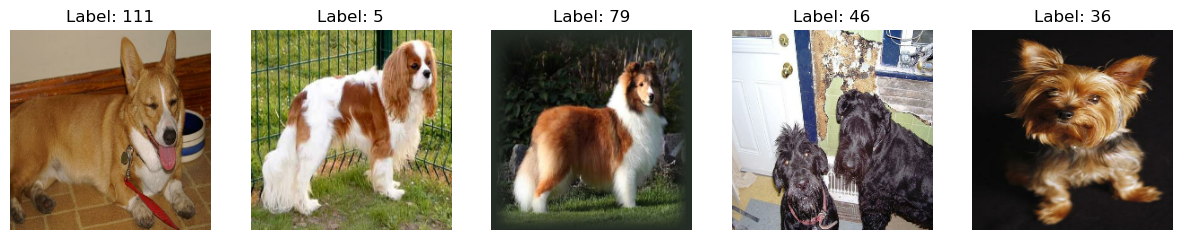

In [4]:
# Display some images from the training dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i].astype("uint8"))
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis('off')
plt.show()

In [5]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, train_images.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(train_images_flat.copy())


Extracting the top 300 eigenfaces from 12000 faces
CPU times: total: 3min 2s
Wall time: 2min 34s


PCA(n_components=300)

In [ ]:
eigenfaces = pca.components_.reshape((n_components, train_images.shape[1], train_images.shape[2], train_images.shape[3]))
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
# Scale the eigenfaces to the range [0, 0.3] for better visualization
eigenfaces =  0.3 * (eigenfaces - eigenfaces.min()) / (eigenfaces.max() - eigenfaces.min())

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i])
    ax.set_title(f"Eigenface {i}")
    ax.axis('off')
plt.show()

In [ ]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1    
X_idx = train_images[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(224, 224,3))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((224,224,3)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((224, 224,3)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

In [6]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

plot_explained_variance(pca)

From the graph, the explained variance begins to stagnate at around 700 principal components and it captures approximately 90% of the explained variance, which is already a significant amount. If we wanted to increase the percentage of explained variance captured to 95%, we would need to use 2200 principal components (more than 3x for 90%), which is significantly increase computational time. Therefore, we concluded to use 1000 principal components.

In [ ]:
n_components = 2500
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, train_images.shape[0]))

rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(train_images_flat.copy())

In [ ]:
plot_explained_variance(rpca)

Similarly, 700 principal components were needed to capture 90% of the explained variance when we used randomized PCA. It too also required more than 3x the amonut of principal components to explain 95% of the explained variance. Therefore, we also concluded, 700 principal components was adequate represent the data.

3.4 Feature Extraction

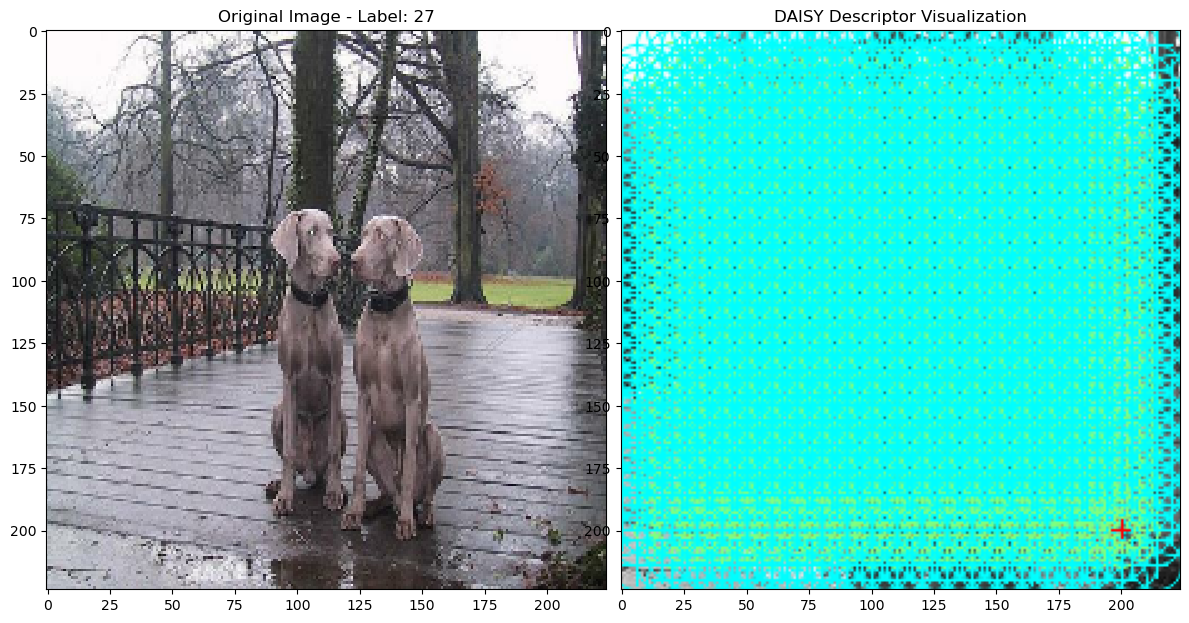

In [10]:
from skimage.feature import daisy
from skimage.color import rgb2gray
from skimage.io import imshow

plt.figure(figsize=(12, 6))

idx_to_reconstruct = np.random.randint(len(train_images))

plt.subplot(1, 2, 1)
img = train_images[idx_to_reconstruct].astype('uint8')
imshow(img)
plt.title(f"Original Image - Label: {train_labels[idx_to_reconstruct]}")
plt.grid(False)

img_gray = rgb2gray(img)
features, img_desc = daisy(img_gray, 
                           step=10, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=4, 
                           visualize=True)
plt.subplot(1, 2, 2)
plt.imshow(img_desc)
plt.title("DAISY Descriptor Visualization")
plt.grid(False)

In [11]:
#apply daisy to one image
features = daisy(img_gray, step=10, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

#function to apply daisy to every image
def apply_daisy(row, shape):
    gray_image = rgb2gray(row)  # Convert image to grayscale
    feat = daisy(gray_image, step=10, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)  
    return feat.reshape((-1))

h, w, c = train_images[0].shape

#test application
test_feature = apply_daisy(train_images[3], (h, w))
print(test_feature.shape)

#application of daisy to every image
daisy_features = np.array([apply_daisy(img, (h, w)) for img in train_images])
print(daisy_features.shape)




(19, 19, 68)
24548
(24548,)
(12000, 24548)


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
import copy

#find closet image to image of idx1 = 4
dist_matrix = pairwise_distances(daisy_features)
idx1 = 4
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty 
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(train_images[idx1].astype("uint8"))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(train_images[idx2].astype("uint8"))
plt.title("Closest Image")
plt.grid()

The above shows the closest image to images in our data set using the daisy image extraction. From trying with differtent images it seems that Daisy is not a suitable fit for our data set as the images it saying are closest are not images of dogs of smilar dog breeds. 